<a href="https://colab.research.google.com/github/DAHYUN-HAN/Machine_Learning/blob/master/Ch04_ML_Training_Models_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Polynomial Regression
What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to **add powers of each feature as new features**, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.

Let’s look at an example. First, let’s generate some nonlinear data, based on a simple quadratic equation7 (plus some noise; see Figure 4-12):



In [0]:
import numpy as np
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

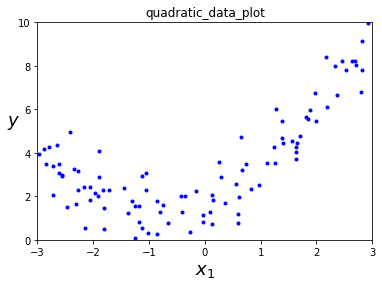

In [2]:
import matplotlib.pyplot as plt

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.title("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly. 

So let’s use Scikit-Learn’s **PolynomialFeatures** class to transform our training data, adding **the square (second-degree polynomial) of each feature** in the training set as a new feature (in this case there is just one feature):

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [4]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of `X` plus **the square of this feature**. 

Now you can fit a LinearRegression model to this extended training data (Figure 4-13):

In [5]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

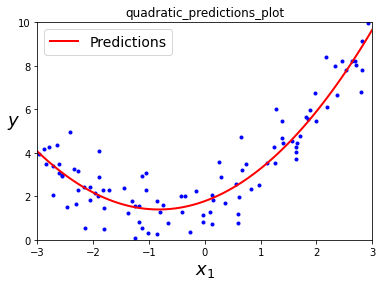

In [6]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.title("quadratic_predictions_plot")
plt.show()

Not bad: the model estimates

$$
\hat{y}=1.781 + 0.9336 x_1 + 0.564 x_1^2
$$

where in fact the original function was 

$$
y= 2.0+1.0x_1+0.5 x_1^2 + \text{Gaussian noise}
$$

Note that when there are multiple features, **Polynomial Regression** is capable of 
* finding relationships between features (which is something a plain Linear Regression model cannot do). 

This is made possible by the fact that **PolynomialFeatures** also adds all combinations of features up to the given `degree`. 

For example, if there were two features $a$ and $b$, **PolynomialFeatures** with `degree=3` would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$, and $ab^2$.

> ### WARNING
>
> **PolynomialFeatures(`degree=d`)** transforms an array containing $n$ features into an array containing $\frac{(n + d)!}{ d!n!}$ features, where $n!$ is the factorial of $n$, equal to $1 × 2 × 3 × ⋯ × n$. Beware of the combinatorial explosion of the number of features!

# Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression. For example, Figure below applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model (second-degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

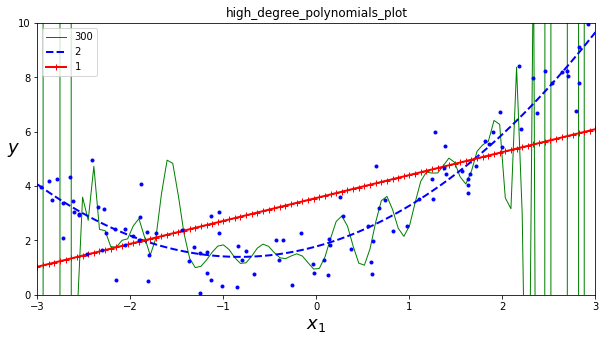

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(10,5))
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)


plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.title("high_degree_polynomials_plot")
plt.show()

This high-degree Polynomial Regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best in this case is the quadratic model, which makes sense because the data was generated using a quadratic model. 

* But in general you won’t know what function generated the data, so 
* **how can you decide how complex your model should be?** 
* **How can you tell that your model is overfitting or underfitting the data?**

In Chapter 2 you used **cross-validation** to get an estimate of a **model’s generalization performance**. 
* If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, 
* then your model is **overfitting**. 
* If it performs poorly on both, 
* then it is **underfitting**. 

This is one way to tell when a model is too simple or too complex.

Another way to tell is to look at **the learning curves**: 
* these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). 

To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model:

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
  plt.legend(loc="upper right", fontsize=14)   # not shown in the book
  plt.xlabel("Training set size", fontsize=14) # not shown
  plt.ylabel("RMSE", fontsize=14)              # not shown

Let’s look at the learning curves of the plain Linear Regression model (a straight line; see Figure 4-15):

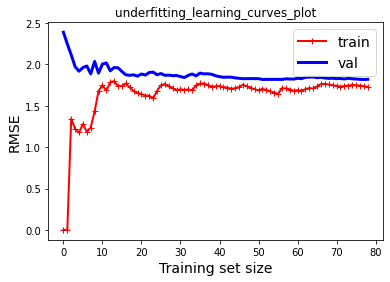

In [9]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
#plt.axis([0, 80, 0, 3])
plt.title("underfitting_learning_curves_plot")
plt.show()                                    


This model that’s **underfitting** deserves a bit of explanation. 

* First, let’s look at the performance on the training data: 
  * when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. 
  * But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is *noisy* and because *it is **not linear** at all*. 
  * So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. 
* Now let’s look at the performance of the model on the validation data. 
   * When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. 
   * Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. 
   * However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.


**These learning curves are typical of a model that’s underfitting**. 
* Both curves have reached a plateau; 
* they are close and fairly **high**.

데이터를 늘리는게 아니고 좀 더 복잡한 모델을 선택해야 한다.

> ### TIP
> **If your model is underfitting the training data, adding more training examples will not help**. 
>
> You need to use a more complex model or come up with better features.

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data (Figure 4-16):

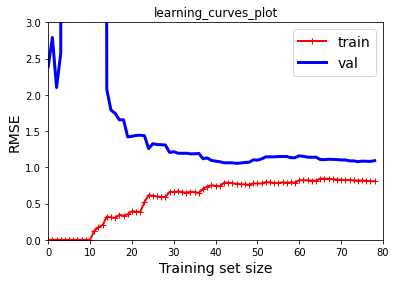

In [10]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)

plt.axis([0, 80, 0, 3])           
plt.title("learning_curves_plot") 
plt.show()                        

오버피트는 train과 val의 rmse가 언더피팅에 비해 조금 떨어져 있다.
모델 자체의 파라미터를 줄여줄지, 파라미터가 작은 값을 가지도록 해 줄지, 트레이닝 데이터의 피처 수들을 진짜 필요한 것들만 남겨 줄일지. 하는게 필요.

These learning curves look a bit like the previous ones, but there are two very important differences:

* The error on the training data is much lower than with the Linear Regression model.
* There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

> ### TIP
>
> One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.